#### 베이스라인 평점
- Baseline Rating : 개인의 성향을 반영해 아이템 평가에 편향성(bias) 요소를 반영하여 평점을 부과하는 것
- 사용자가 특정 아이템과 유사한 아이템에 대한 평점을 준 적이 없을 때는 해당 아이템에 대한 예측 평점을 어떻게 줄 수 있을까 ? 

- 일반적인 베이스라인 평점 : 전체 평균 평점 + 사용자 편향 점수 + 아이템 편향 점수
     - 전체 평균 평점 : 모든 사용자의 아이템에 대한 평점 평균한 값
     - 사용자 편향 점수 : 사용자별 아이템 평균 값 - 전체 평균 평점
     - 아이템 편향 점수 : 아이템별 평점 평균 값 - 전체 평점 평균
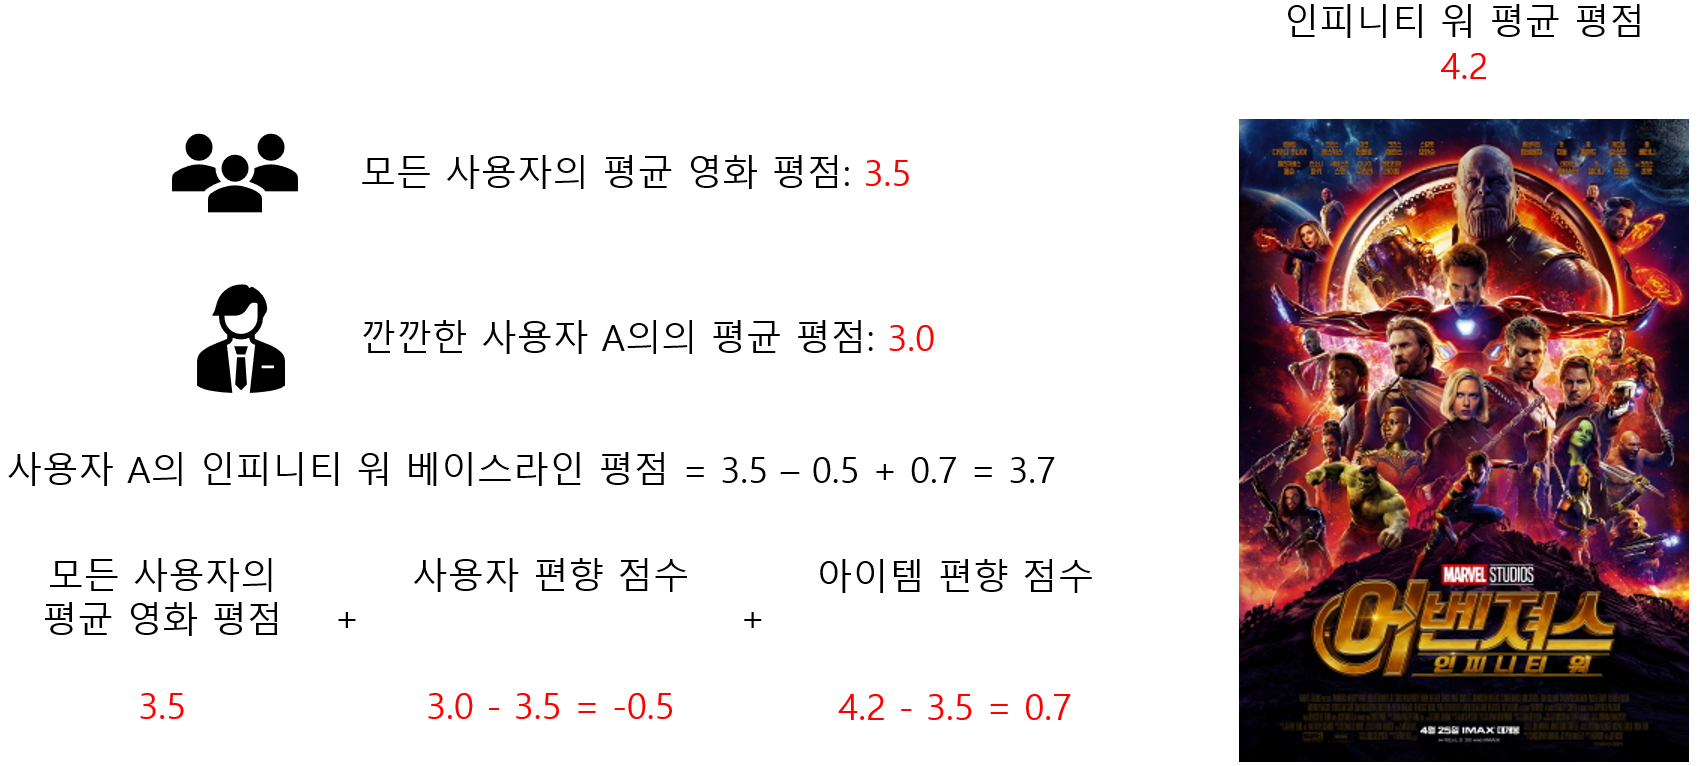

- 사용자 아이디 u, 상품 아이디 i, 두 개의 카테고리 값 입력에서   
평점 $r(u,i)$의 예측치 $\hat{r}(u,i)$를 예측하는 가장 단순한 회귀분석 모형
$\hat{r}(u,i) = \mu + b(u) + b(i)$
- $\mu$ : 전체 평점 평균
- $b(u)$ : 동일 사용자에 의한 평점 조정 값
- $b(i)$ : 동일한 상품에 대한 평점 조정 값


- 베이스라인 모형은 다음 오차 함수를 최소화하도록 구해짐   
$\sum_{u,i \in R_{train}} \left(r(u,i) - \hat{r}(u,i))\right)^2$
- $R_{train}$ : 실제 평점이 존재하는 학습용 데이터 집합


- 과최적화를 피하기 위해 다음과 같이 정규화 항을 추가할 수 있음   
$\sum_{u,i \in R_{train}} \left(r(u,i) - \hat{r}(u,i))\right)^2 + \lambda \left(b(u)^2 + b(i)^2 \right)$


- 베이스라인 모형에 추천 시스템 모형들을 적용하면 좀 더 정확한 예측 가능 ! 

#### 교차 검증과 하이퍼 파라미터 튜닝
- 사이킷런과 유사한 cross_validate() , GridSearchCV 클래스 제공

In [15]:
# cross_validate() 예제
from surprise.model_selection import cross_validate

ratings = pd.read_csv('./data/ratings.csv')
reader = Reader(rating_scale=(0.5,5.0))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)

algo = SVD(random_state=0)
cross_validate(algo, data, measures=['RMSE','MAE'],cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8635  0.8733  0.8781  0.8754  0.8728  0.8726  0.0049  
MAE (testset)     0.6632  0.6703  0.6726  0.6750  0.6696  0.6701  0.0040  
Fit time          9.03    7.80    7.72    7.59    7.88    8.00    0.52    
Test time         0.39    0.38    0.25    0.24    0.24    0.30    0.07    


{'test_rmse': array([0.86348374, 0.8733156 , 0.87812007, 0.8753562 , 0.8727879 ]),
 'test_mae': array([0.6631943 , 0.67025948, 0.67262039, 0.67498172, 0.66959898]),
 'fit_time': (9.026531457901001,
  7.8011932373046875,
  7.717482566833496,
  7.59454870223999,
  7.877492427825928),
 'test_time': (0.39246273040771484,
  0.3789863586425781,
  0.2533285617828369,
  0.24434828758239746,
  0.23537182807922363)}

In [17]:
# GrideSearchCV 실습
# SVD의 경우 점진적 하강 방식의 반복 횟수 지정하는 n_epochs와 잠재요인 K의 크기 지정하는 n_factors 튜닝
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs':[20,40,60], 'n_factors':[50,100,200]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse','mae'],cv=3)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8768761192674067
{'n_epochs': 20, 'n_factors': 50}


#### Surprise를 이용한 개인화 영화 추천 시스템 구축
- Surprise는 train_test_split()을 이용해 내부에서 사용하는 TrainSet 클래스 객체로 변환 필요함
- 데이터 세트 전체를 학습데이터로 사용하려면 DatasetAutoFolds 클래스 이용

In [18]:
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5,5))
data_folds = DatasetAutoFolds(ratings_file = './data/ratings_noh.csv', reader=reader)

trainset = data_folds.build_full_trainset()

In [19]:
algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)

In [20]:
movies = pd.read_csv('./data/movies.csv')

movieIds = ratings[ratings['userId']==9]['movieId']
if movieIds[movieIds==42].count() == 0:
    print('사용자 아이디 9는 영화 아이디 42의 평점 없음')

print(movies[movies['movieId']==42])

사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


In [21]:
uid = str(9)
iid = str(42)

pred =  algo.predict(uid, iid, verbose=True)
# 3.13 으로 예측

user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


In [23]:
# 평점 매기지 않은 전체 영화 추출 후 예측 평점 순으로 영화 추천
def get_unseen_surprise(ratings, movies, userId):
    # 평점 매긴 모든 영화 리스트로 생성
    seen_movies = ratings[ratings['userId']==userId]['movieId'].tolist()
    
    # 모든 영화의 movieId 리스트로 생성
    total_movies = movies['movieId'].tolist()
    
    unseen_movies = [movie for movie in total_movies if movie not in  seen_movies]
    print('평점 매긴 영화 수:',len(seen_movies), '추천 대상 영화 수:',len(unseen_movies),
         '전체 영화 수:', len(total_movies))
    
    return unseen_movies

unseen_movies = get_unseen_surprise(ratings, movies, 9)

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742


In [24]:
# SVD 이용해 평점 예측 후 추천해주는 함수 생성
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
    predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]
    
# est값으로 정렬하기 위해 sortkey_est 함수 정의
    def sortkey_est(pred):
        return pred.est
    
    predictions.sort(key=sortkey_est, reverse=True)
    top_predictions = predictions[:top_n]
    
    top_movie_ids = [int(pred.iid) for pred in top_predictions]
    top_movie_rating = [pred.est for pred in top_predictions]
    top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]['title']
    
    top_movie_preds = [(id,title,rating) for id,title,rating in zip(top_movie_ids, top_movie_titles, top_movie_rating)]
    
    return top_movie_preds

In [25]:
unseen_movies = get_unseen_surprise(ratings, movies, 9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)

print('##### Top-10 추천 영화 리스트 #####')
for top_movie in top_movie_preds:
    print(top_movie[1],':',top_movie[2])

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742
##### Top-10 추천 영화 리스트 #####
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122759
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122658
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957


복잡한 알고리즘을 직접 구현하지 않고도 쉽고 간결한 API를 이용해 파이썬 기반의 추천 시스템 구축할 수 있음

### 9. 정리

- 온라인 스토어의 경우 뛰어난 추천 시스템은 매출 향상으로 이어지는 사례가 많음

**콘텐츠 기반 필터링**   
아이템(상품,영화,서비스 등) 구성하는 여러 콘텐츠 중 사용자가 가장 좋아하는 아이템 분석한 뒤, 해당 콘텐츠와 유사한 다른 콘텐츠 추천   
영화의 경우 (장르,감독,영화배우,영화 키워드) 등의 요소들을 결합하여 하나의 콘텐츠 특징으로 피처 벡터화 한 뒤 이들 피처 벡터와 가장 유사한 다른 피처 벡터 가진 영화 추천

**협업 필터링**
1. 최근접 이웃 협업 필터링   
    1-1. 사용자 기반(사용자-사용자)   
    1-2. 아이템 기반(아이템-아이템)   
    유사도 기준 : 사용자들의 아이템에 대한 평가 벡터화한 값   
2. 잠재 요인 협업 필터링
    - 많은 추천 시스템에서 활용하는 방식
    - 사용자-아이템 평점 행렬 데이터에서 숨어 있는 잠재 요인 추출해 아직 평점을 매기지 않은 아이템에 대한 평점 예측해 이를 추천에 반영하는 방식
    - 다차원 사용자-아이템 평점 행렬 -> 저차원의 사용자-잠재요인/아이템-잠쟁요인 행렬로 분해 필요

**Surprise 패키지**
- 사이킷런과 유사한 API 지향
- 간단한 API만으로 파이썬 기반에서 추천 시스템 구현



추천 시스템의 기반 지식과 구현 로직에 대한 철저한 이해가 필수적임 ! 